In [1]:
import numpy as np
import time
from xclib.data import data_utils
import matplotlib.pyplot as plt

In [2]:
def read_files(x, y):
    x = '../ass3_parta_data/' + x
    f = open(x, 'r')
    line = f.readline().rstrip("\n").split(" ")
    num_samples, num_feat = int(line[0]), int(line[1])
    data_x = np.zeros((num_samples, num_feat))
    i = 0
    for line in f:
        line = line.split(" ")
        for value in line:
            value = value.split(":")
            data_x[i][int(value[0])] = float(value[1])
        i += 1
    
    data_y = np.genfromtxt('../ass3_parta_data/' + y, delimiter=' ')
    
    return data_x, data_y

s = time.time()
x_train, y_train = read_files('train_x.txt', 'train_y.txt')
x_val, y_val = read_files('valid_x.txt', 'valid_y.txt')
x_test, y_test = read_files('test_x.txt', 'test_y.txt')
print("Data imported in ", time.time()-s, "s")

Data imported in  5.6657819747924805 s


In [3]:
class Node:
    # Initializer
    def __init__(self, i, t, left, right, label, is_leaf):
        self.index = i
        self.threshold = t
        self.left = left
        self.right = right
        self.label = label
        self.is_leaf = is_leaf
    
    def set_leaf(self):
        self.is_leaf = True
    
    def unset_leaf(self):
        self.is_leaf = False
        
    def to_string(self):
        return str(self.index)+" "+str(self.threshold)+" "+str(self.left)+" "+str(self.right)
        
def get_height(a):   
    if(a==None):
        return -1
    elif(a.is_leaf):
        return 0
    else:
        left_height = get_height(a.left)
        right_height = get_height(a.right)
        return 1 + max(left_height, right_height)
    
def node_count(a):
    if(a==None):
        return 0
    elif(a.is_leaf):
        return 0
    else:
        return 1 + node_count(a.left) + node_count(a.right)
    
def node_leaves_count(a):
    if(a==None):
        return 0
    elif(a.is_leaf):
        return 1
    else:
        return 1 + node_leaves_count(a.left) + node_leaves_count(a.right)

In [4]:
def entropy(count_0, count_1):
    
    h_y = None
    
    if(count_0==0 or count_1==0):
        h_y = 0
    else:
        p_0 = count_0/(count_0 + count_1)
        p_1 = count_1/(count_0 + count_1)
        h_y = -(p_0*np.log2(p_0) + p_1*np.log2(p_1))
        
    return h_y

def best_attribute(dataset, y, count_0, count_1):
    
    h_y = entropy(count_0, count_1)
    
    medians = np.median(dataset, axis = 0)
    non_zeros = np.count_nonzero(dataset, axis=0)
    
    best_index = -1
    best_ig = -float('inf')
    best_median = None
    
    total = count_0 + count_1
    
    for index, median in enumerate(medians):
        
        if(non_zeros[index] == 0):
            if(0>best_ig):
                best_index = index
                best_ig = 0
                best_median = median 
        
        index_neg = np.argwhere(dataset[:,index] <= median).flatten()
        index_pos = np.argwhere(dataset[:,index] > median).flatten()
        count_neg = index_neg.shape[0]
        count_pos = index_pos.shape[0]
        
        if(count_neg==total or count_pos==total):
            if(0>best_ig):
                best_index = index
                best_ig = 0
                best_median = median
        else:
            
            y_neg = y[index_neg]
            y_pos = y[index_pos]
            
            count_1_neg = np.count_nonzero(y_neg)
            entropy_neg = (count_neg/total) * entropy(count_neg - count_1_neg, count_1_neg)
            
            count_1_pos = np.count_nonzero(y_pos)
            entropy_pos = (count_pos/total) * entropy(count_pos - count_1_pos, count_1_pos)
            
            ig = h_y - entropy_neg - entropy_pos
            
            if(ig>best_ig):
                best_index = index
                best_ig = ig
                best_median = median
        
    return best_index, best_median

In [5]:
def grow_tree(dataset, y):
    
    count = y.shape[0]
    
    if(count==0):
        return None
    
    index_0 = np.argwhere(y==0)
    index_1 = np.argwhere(y==1)
    
    if(index_1.shape[0] == count):
        return Node(None, None, None, None, 1, True)
    elif(index_0.shape[0] == count):
        return Node(None, None, None, None, 0, True)
    else:
        
        label = -1
        if(index_1.shape[0] > index_0.shape[0]):
            label = 1
        else:
            label = 0
            
        index, threshold = best_attribute(dataset, y, index_0.shape[0], index_1.shape[0])
        
        index_neg = np.argwhere(dataset[:,index] <= threshold).flatten()
        index_pos = np.argwhere(dataset[:,index] > threshold).flatten()
        
        data_0, y_0 = dataset[index_neg][:], y[index_neg]
        data_1, y_1 = dataset[index_pos][:], y[index_pos]
        
        if(y_1.shape[0] == 0 or y_0.shape[0] == 0):
            return Node(index, threshold, None, None, label, True)
        
        return Node(index, threshold, grow_tree(data_0, y_0), grow_tree(data_1, y_1), label, False)

In [22]:
def pred_row(root, row):
    if(root == None):
        return -1
    elif(root.is_leaf):
        return root.label
    else:
        i = root.index
        t = root.threshold
        if(row[i] <= t):
            return pred_row(root.left, row)
        else:
            return pred_row(root.right, row)


def pred_new(root, row):
    n = root
    while((n!=None)):
        if(n.is_leaf):
            return n.label
        else:
            i = n.index
            t = n.threshold
            if(row[i] <= t):
                n = n.left
            else:
                n = n.right
    return -1

def accuracy_new(root, x, y):
    res = np.vectorize(lambda i: pred_new(root, x[i]))(np.arange(y.shape[0]))
    err = abs(y - res).sum()
    return 1 - err/y.shape[0]


def accuracy(root, x, y):
    count = 0
    
    for index, row in enumerate(x):
        if(pred_row(root, row) == int(y[index])):
            count +=1
    
    return count/len(y)

In [57]:
s = time.time()
root = grow_tree(x_train, y_train)
print("Time taken is:",time.time()-s)

Time taken is: 115.83327269554138


In [30]:
def bfs(root):
    
    check = [root]
    bfs = []
    
    while(len(check) > 0):
        
        n = check.pop(0)
        
        if(n.is_leaf or n==None):
            continue        
        
        check.append(n.left)
        check.append(n.right)
        bfs.append(n)
        
    return bfs

In [48]:
def bfs_prune(bfs_list):
    
    best_acc = accuracy_new(root, x_val, y_val)
    
    while(len(bfs_list) > 0):
        
        node = bfs_list.pop()
        
        node.is_leaf = True
        acc = accuracy_new(root, x_val, y_val)
        
        if(acc > best_acc):
            return True
        else:
            node.is_leaf = False
        
        print(len(bfs_list))
    return False

In [49]:
def max_prune(bfs_list):
    
    curr_acc = accuracy_new(root, x_val, y_val)
    prune_node = None
    
    while(len(bfs_list) > 0):
        
        node = bfs_list.pop()
        
        node.is_leaf = True
        acc = accuracy_new(root, x_val, y_val)
        
        if(acc > curr_acc):
            curr_acc = acc
            prune_node = node
        
        node.is_leaf = False
    
    if(prune_node == None):
        return False
    else:
        prune_node.is_leaf = True
        return True

In [50]:
b_l = bfs(root)

In [54]:
for i in b_l:
    i.is_leaf = False

In [40]:
s = time.time()

acc_val = [accuracy_new(root, x_val, y_val)]
acc_test = [accuracy_new(root, x_test, y_test)]
acc_train = [accuracy_new(root, x_train, y_train)]
node_count = [node_leaves_count(root)]

print(acc_val, acc_test, acc_train, node_count)

prune_count = 0
bfs_list = bfs(root)

while(True):
    
    s1 = time.time()
    print("Going for prune_count: ", prune_count+1)
    res = bfs_prune(bfs_list)
    print("Done for prune_count: ", prune_count+1, "in time:", time.time()-s1)
    
    if(res):
        
        acc_val.append(accuracy_new(root, x_val, y_val))
        acc_test.append(accuracy_new(root, x_test, y_test))
        acc_train.append(accuracy_new(root, x_train, y_train))
        
        count = node_leaves_count(root)
        node_count.append(count)
        
        prune_count += 1
        print("Node Count: ", count)
        
        continue
        
    break
    
print("Pruning done, time taken : ", time.time()-s)

[0.7763767847209345] [0.7799823837559686] [0.9045786781635838] [20011]
Going for prune_count:  1
10004
10003
10002
10001
Done for prune_count:  1 in time: 0.698371410369873
Node Count:  19483
Going for prune_count:  2
9999
9998
9997
Done for prune_count:  2 in time: 0.741995096206665
Node Count:  18861
Going for prune_count:  3
9995
9994
Done for prune_count:  3 in time: 0.6490561962127686
Node Count:  12233
Going for prune_count:  4
9992
Done for prune_count:  4 in time: 0.401641845703125
Node Count:  12165
Going for prune_count:  5
9990
9989
9988
9987
9986
9985
9984
9983
9982
9981
9980
Done for prune_count:  5 in time: 1.6745245456695557
Node Count:  12089
Going for prune_count:  6
9978
9977
9976
Done for prune_count:  6 in time: 0.6960546970367432
Node Count:  12073
Going for prune_count:  7
9974
9973
9972
9971
9970
9969
9968
9967
9966
9965
9964
9963
9962
9961
9960
9959
9958
9957
9956
9955
9954
Done for prune_count:  7 in time: 3.7582664489746094
Node Count:  12071
Going for prune_c

Node Count:  8537
Going for prune_count:  46
9219
9218
9217
9216
9215
9214
9213
9212
Done for prune_count:  46 in time: 1.1775257587432861
Node Count:  8515
Going for prune_count:  47
9210
9209
9208
9207
9206
9205
9204
9203
9202
9201
9200
9199
9198
9197
9196
9195
9194
9193
9192
9191
9190
9189
9188
9187
9186
9185
9184
9183
9182
9181
9180
Done for prune_count:  47 in time: 3.892308473587036
Node Count:  8503
Going for prune_count:  48
9178
9177
9176
9175
Done for prune_count:  48 in time: 0.6885180473327637
Node Count:  8489
Going for prune_count:  49
9173
9172
9171
9170
9169
9168
Done for prune_count:  49 in time: 0.9166977405548096
Node Count:  8481
Going for prune_count:  50
9166
9165
9164
Done for prune_count:  50 in time: 0.5956671237945557
Node Count:  8469
Going for prune_count:  51
Done for prune_count:  51 in time: 0.2275543212890625
Node Count:  8455
Going for prune_count:  52
9161
9160
9159
9158
9157
9156
9155
9154
Done for prune_count:  52 in time: 1.180835247039795
Node Coun

8208
8207
8206
8205
8204
8203
8202
8201
8200
8199
8198
8197
8196
8195
8194
8193
8192
8191
8190
8189
8188
8187
8186
8185
8184
8183
8182
Done for prune_count:  79 in time: 5.3167595863342285
Node Count:  5769
Going for prune_count:  80
8180
8179
8178
8177
Done for prune_count:  80 in time: 1.023674488067627
Node Count:  5717
Going for prune_count:  81
8175
8174
8173
8172
8171
8170
8169
Done for prune_count:  81 in time: 1.0734193325042725
Node Count:  5705
Going for prune_count:  82
8167
8166
8165
8164
Done for prune_count:  82 in time: 0.6900279521942139
Node Count:  5699
Going for prune_count:  83
8162
8161
8160
8159
8158
8157
8156
8155
8154
8153
8152
8151
Done for prune_count:  83 in time: 1.8115012645721436
Node Count:  5671
Going for prune_count:  84
8149
8148
8147
8146
8145
8144
8143
8142
8141
8140
8139
8138
8137
8136
8135
8134
8133
8132
8131
8130
8129
8128
8127
8126
8125
8124
8123
8122
8121
8120
8119
8118
8117
8116
8115
8114
8113
8112
8111
8110
8109
8108
8107
8106
8105
8104
Done f

6924
6923
6922
6921
6920
6919
6918
6917
6916
6915
6914
6913
6912
6911
6910
6909
6908
6907
6906
6905
6904
6903
6902
6901
6900
6899
6898
6897
6896
6895
6894
6893
6892
6891
6890
6889
6888
6887
6886
6885
6884
6883
6882
6881
6880
6879
6878
6877
6876
6875
6874
6873
6872
6871
6870
6869
6868
6867
6866
6865
6864
6863
6862
6861
6860
6859
6858
6857
6856
6855
6854
6853
6852
6851
6850
6849
6848
6847
6846
6845
6844
6843
6842
6841
6840
6839
6838
6837
6836
6835
6834
6833
6832
6831
6830
6829
6828
6827
6826
6825
6824
6823
6822
6821
6820
6819
6818
6817
6816
6815
6814
6813
6812
6811
6810
6809
6808
6807
6806
6805
6804
6803
6802
6801
6800
Done for prune_count:  98 in time: 38.88726854324341
Node Count:  3919
Going for prune_count:  99
6798
6797
6796
6795
6794
6793
6792
Done for prune_count:  99 in time: 0.9289555549621582
Node Count:  3899
Going for prune_count:  100
6790
6789
6788
6787
6786
6785
6784
6783
6782
6781
6780
6779
6778
6777
6776
6775
6774
6773
6772
6771
6770
6769
6768
6767
6766
6765
6764
6763
67

5607
5606
5605
5604
5603
5602
5601
5600
5599
5598
5597
5596
5595
5594
5593
5592
5591
5590
5589
5588
5587
5586
5585
5584
5583
5582
5581
5580
5579
5578
5577
5576
5575
5574
5573
5572
5571
5570
5569
5568
5567
5566
5565
5564
5563
5562
5561
5560
5559
5558
5557
5556
5555
5554
5553
Done for prune_count:  115 in time: 6.7083070278167725
Node Count:  3431
Going for prune_count:  116
5551
5550
5549
5548
5547
5546
5545
5544
5543
5542
5541
5540
5539
5538
5537
5536
5535
5534
5533
5532
5531
5530
5529
5528
5527
5526
5525
5524
5523
5522
5521
5520
5519
5518
5517
5516
5515
5514
5513
5512
5511
5510
5509
5508
5507
5506
5505
5504
5503
5502
5501
5500
5499
5498
5497
5496
5495
5494
5493
5492
5491
5490
5489
5488
5487
5486
5485
5484
5483
5482
5481
5480
5479
5478
5477
5476
5475
5474
5473
5472
5471
5470
5469
5468
5467
5466
5465
5464
5463
5462
5461
5460
5459
5458
5457
5456
5455
5454
5453
5452
5451
5450
5449
5448
5447
5446
5445
5444
5443
5442
5441
5440
Done for prune_count:  116 in time: 11.208665609359741
Node Coun

4100
4099
4098
4097
4096
4095
4094
4093
4092
4091
4090
4089
4088
4087
4086
4085
4084
4083
4082
4081
4080
4079
4078
4077
4076
4075
4074
4073
4072
4071
4070
4069
4068
4067
4066
4065
4064
4063
4062
4061
4060
4059
4058
4057
4056
4055
4054
4053
4052
4051
4050
4049
4048
4047
4046
4045
4044
4043
4042
4041
4040
4039
4038
4037
4036
4035
4034
4033
4032
4031
4030
4029
4028
4027
4026
4025
4024
4023
4022
4021
4020
4019
4018
4017
4016
4015
4014
4013
4012
4011
4010
4009
4008
4007
4006
4005
4004
4003
4002
4001
4000
3999
3998
3997
3996
3995
3994
3993
3992
3991
3990
3989
3988
3987
3986
3985
3984
3983
3982
3981
3980
3979
3978
3977
3976
3975
3974
3973
3972
3971
3970
3969
3968
3967
3966
3965
3964
3963
3962
3961
3960
3959
3958
3957
3956
3955
3954
3953
3952
3951
3950
3949
3948
3947
3946
3945
3944
3943
3942
3941
3940
3939
3938
3937
3936
3935
3934
3933
3932
3931
3930
3929
3928
3927
3926
3925
3924
3923
3922
3921
3920
3919
3918
3917
3916
3915
3914
3913
3912
3911
3910
3909
3908
3907
3906
3905
3904
3903
3902
3901


2652
2651
2650
2649
2648
2647
2646
2645
2644
2643
2642
2641
2640
2639
2638
2637
2636
2635
2634
2633
2632
2631
2630
2629
2628
2627
2626
2625
2624
2623
2622
2621
2620
2619
2618
2617
2616
2615
2614
2613
2612
2611
2610
2609
2608
2607
2606
2605
2604
2603
2602
2601
2600
2599
2598
2597
2596
2595
2594
2593
2592
2591
2590
2589
2588
2587
2586
2585
2584
2583
2582
2581
2580
2579
2578
2577
2576
2575
2574
2573
2572
2571
2570
2569
2568
2567
2566
2565
2564
2563
2562
2561
2560
2559
2558
2557
2556
2555
2554
2553
2552
2551
2550
2549
2548
2547
2546
2545
2544
2543
2542
2541
2540
2539
2538
2537
2536
2535
2534
2533
2532
2531
2530
2529
2528
2527
2526
2525
2524
2523
2522
2521
2520
2519
2518
2517
2516
2515
2514
2513
2512
2511
2510
2509
2508
2507
2506
2505
2504
2503
2502
2501
2500
2499
2498
2497
2496
2495
2494
2493
2492
2491
2490
2489
2488
2487
2486
2485
2484
2483
2482
2481
2480
2479
2478
2477
2476
2475
2474
2473
2472
2471
2470
2469
2468
2467
2466
2465
2464
2463
2462
2461
2460
2459
2458
2457
2456
2455
2454
2453


Node Count:  2773
Going for prune_count:  141
1174
1173
1172
1171
1170
1169
1168
1167
1166
1165
1164
1163
1162
1161
1160
1159
1158
1157
1156
1155
1154
1153
1152
1151
1150
1149
1148
1147
1146
1145
1144
1143
1142
1141
1140
1139
1138
1137
1136
1135
1134
1133
1132
1131
1130
1129
1128
1127
1126
1125
1124
1123
1122
1121
1120
1119
1118
1117
1116
1115
1114
1113
1112
1111
1110
1109
1108
1107
1106
1105
1104
1103
1102
1101
1100
1099
1098
1097
1096
1095
1094
1093
1092
1091
1090
1089
1088
1087
1086
1085
1084
1083
1082
1081
1080
1079
1078
1077
1076
1075
1074
1073
1072
1071
1070
1069
1068
1067
1066
1065
1064
1063
1062
1061
1060
1059
1058
1057
1056
1055
1054
1053
1052
1051
1050
1049
1048
1047
1046
1045
1044
1043
1042
1041
1040
1039
1038
1037
1036
1035
1034
1033
1032
1031
1030
1029
1028
1027
1026
1025
1024
1023
1022
1021
1020
1019
1018
1017
1016
1015
1014
1013
1012
1011
1010
1009
1008
1007
1006
1005
1004
1003
1002
1001
1000
999
998
997
996
995
994
993
992
991
990
989
988
987
986
985
984
983
982
981
Don

In [34]:
prune_count

1

In [41]:
node_count

[20011,
 19483,
 18861,
 12233,
 12165,
 12089,
 12073,
 12071,
 12029,
 11991,
 11931,
 11887,
 11873,
 11853,
 11851,
 11707,
 10927,
 10771,
 10767,
 10499,
 10375,
 10373,
 10367,
 10335,
 10297,
 10283,
 10237,
 10177,
 10167,
 10135,
 10131,
 9969,
 9809,
 9759,
 9295,
 9241,
 9211,
 9179,
 9139,
 9107,
 9067,
 9051,
 8661,
 8569,
 8555,
 8537,
 8515,
 8503,
 8489,
 8481,
 8469,
 8455,
 8453,
 8297,
 7657,
 7217,
 7215,
 7203,
 7119,
 7059,
 7057,
 6989,
 6985,
 6975,
 6953,
 6937,
 6667,
 6429,
 6419,
 6315,
 6309,
 6297,
 6291,
 6265,
 6251,
 6237,
 6037,
 5777,
 5773,
 5769,
 5717,
 5705,
 5699,
 5671,
 5645,
 5567,
 5527,
 5491,
 5469,
 5405,
 5383,
 5349,
 5333,
 3987,
 3985,
 3949,
 3947,
 3941,
 3919,
 3899,
 3865,
 3827,
 3807,
 3793,
 3787,
 3781,
 3649,
 3631,
 3611,
 3601,
 3555,
 3537,
 3529,
 3525,
 3449,
 3431,
 3397,
 3383,
 3351,
 3343,
 3333,
 3311,
 3263,
 3241,
 3239,
 3235,
 3207,
 3167,
 3149,
 3103,
 3069,
 3039,
 2961,
 2957,
 2913,
 2875,
 2843,
 2815,
 28

In [42]:
acc_val

[0.7763767847209345,
 0.7767939922121269,
 0.7772575560912294,
 0.7807806415724087,
 0.7809660671240497,
 0.7810587798998703,
 0.7811514926756907,
 0.7812442054515112,
 0.7812905618394215,
 0.7815223437789728,
 0.781568700166883,
 0.7818004821064343,
 0.7818468384943446,
 0.7819859076580753,
 0.7820322640459856,
 0.7820786204338958,
 0.7821713332097163,
 0.7826348970888188,
 0.7826812534767291,
 0.7827739662525496,
 0.7831911737437419,
 0.7832375301316521,
 0.7832838865195624,
 0.7833302429074727,
 0.783376599295383,
 0.7834229556832931,
 0.7835620248470239,
 0.7837010940107547,
 0.7837938067865752,
 0.7839328759503059,
 0.7839792323382162,
 0.7840719451140368,
 0.7841646578898572,
 0.7843500834414983,
 0.7851844984238828,
 0.7856944186908956,
 0.7857871314667161,
 0.7858798442425367,
 0.7859725570183571,
 0.7860652697941777,
 0.7862043389579084,
 0.7862506953458186,
 0.7862970517337289,
 0.7864361208974597,
 0.7865751900611904,
 0.7866679028370109,
 0.7867142592249212,
 0.786760615612

In [43]:
acc_test

[0.7799823837559686,
 0.780167817903667,
 0.7809095544944602,
 0.7846645959853507,
 0.7846645959853507,
 0.7850818228176719,
 0.7852208984284456,
 0.7852208984284456,
 0.7852672569653701,
 0.7854526911130685,
 0.7855917667238422,
 0.7856381252607667,
 0.785823559408465,
 0.7857308423346159,
 0.7856844837976913,
 0.785823559408465,
 0.7857308423346159,
 0.7863335033146354,
 0.7862871447777108,
 0.78637986185156,
 0.7863335033146354,
 0.78637986185156,
 0.7865652959992583,
 0.7865652959992583,
 0.7864725789254091,
 0.7865189374623337,
 0.7866580130731075,
 0.7865652959992583,
 0.7865189374623337,
 0.7866116545361829,
 0.7866580130731075,
 0.7862871447777108,
 0.7862407862407863,
 0.7863335033146354,
 0.7880024106439201,
 0.788234203328543,
 0.788234203328543,
 0.7884196374762412,
 0.7885123545500904,
 0.7885123545500904,
 0.7885123545500904,
 0.7885123545500904,
 0.7886514301608641,
 0.7886050716239396,
 0.7886977886977887,
 0.7886514301608641,
 0.7887905057716378,
 0.7888368643085624,
 

In [44]:
acc_train

[0.9045786781635838,
 0.9035742431968847,
 0.8981039358397849,
 0.8616661258170693,
 0.8614343331324463,
 0.8610943705283328,
 0.8608471249980684,
 0.8608162193067853,
 0.8607389550785778,
 0.8605226152395964,
 0.8600744827159922,
 0.8597808786488031,
 0.8596108973467464,
 0.8593791046621235,
 0.8593481989708405,
 0.8591473119775006,
 0.8545423639763262,
 0.8537233631573254,
 0.8536924574660424,
 0.8524253241234373,
 0.8514981533849458,
 0.8514672476936628,
 0.8514363420023797,
 0.8511272850895493,
 0.8509109452505679,
 0.8508182281767187,
 0.8505246241095298,
 0.8501537558141332,
 0.8501073972772086,
 0.8499219631295103,
 0.8499065102838688,
 0.848824811088962,
 0.84758858343764,
 0.8474186021355833,
 0.8443743915442028,
 0.8437717305641834,
 0.8436017492621266,
 0.8432772395036546,
 0.8430145411277487,
 0.8428136541344089,
 0.8425200500672199,
 0.8422264460000309,
 0.8413456337984639,
 0.8409129541205013,
 0.8408202370466522,
 0.8406502557445954,
 0.8404802744425386,
 0.8404339159056

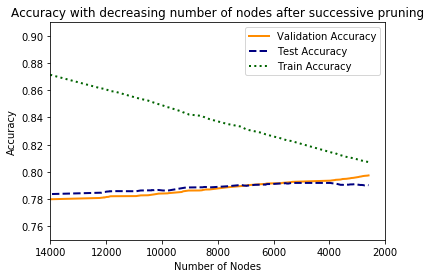

In [46]:
plt.figure()
lw=2
plt.plot(node_count, acc_val, color='darkorange', lw=lw, label='Validation Accuracy')
plt.plot(node_count, acc_test, color='navy', lw=lw, linestyle='--', label='Test Accuracy')
plt.plot(node_count, acc_train, color='darkgreen', lw=lw, linestyle='dotted', label='Train Accuracy')
plt.xlim([14000, 2000])
plt.ylim([0.75, 0.91])
plt.ylabel('Accuracy')
plt.xlabel('Number of Nodes')
plt.title('Accuracy with decreasing number of nodes after successive pruning')
plt.legend(loc="upper right")
plt.show()

In [47]:
max(acc_test)

0.7918965277455844

In [52]:
node_leaves_count(root), 

2599

In [56]:
len(b_l)

1299

In [ ]:
# def bfs_prune(bfs_list):
    
#     best_acc = accuracy_new(root, x_val, y_val)
    
#     while(len(bfs_list) > 0):
        
#         node = bfs_list.pop()
        
#         node.is_leaf = True
#         acc = accuracy_new(root, x_val, y_val)
        
#         if(acc > best_acc):
#             return True
#         else:
#             node.is_leaf = False
        
#         print(len(bfs_list))
#     return False

In [ ]:
# def max_prune(bfs_list):
    
#     curr_acc = accuracy_new(root, x_val, y_val)
#     prune_node = None
    
#     while(len(bfs_list) > 0):
        
#         node = bfs_list.pop()
        
#         node.is_leaf = True
#         acc = accuracy_new(root, x_val, y_val)
        
#         if(acc > curr_acc):
#             curr_acc = acc
#             prune_node = node
        
#         node.is_leaf = False
    
#     if(prune_node == None):
#         return False
#     else:
#         prune_node.is_leaf = True
#         return True